<a href="https://colab.research.google.com/github/fjtm/Data/blob/master/dogsVScats_francisco_javier_tebar_martinez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Comentarios profesor:

Utilizar accuracy. 

Parecido a Random Forest.

Primer bloque tratamiento de los datos. Cargar y tratar las imágenes (resize...), cada imagen tiene un tamaño diferente. 
Escalar las imágnes, montar el tensor, normalizar a (-0.5, 0.5). No pintar la versión normalizada. 

Random suffle para mezclar perros y gatos. 

Modelo básico. 

Conseguir almenos un 60% de accuracy

Para mejorar el modelo (opcional).

Earlystopping (recomendable).

Gridsearch (sin gpu no hacerlo). 

Tecnicas de aumentación de datos (recomendable).


Al final un informe, diciendo lo que hemos probado y que da...


Empezar con imágnes pequeñas y luego ir subiendo. 

# Lab assignment: dogs VS cats

<table><tr>
    <td><img src="https://raw.githubusercontent.com/fjtm/Data/master/img/doge.jpg"   height="400" width="400"></td>
    <td><img src="https://raw.githubusercontent.com/fjtm/Data/master/img/cat.jpg" height="400" width="400"></td>
</tr></table>

In this assignment we will face an image classification problem, trying to tell apart images of dogs and images of cats. The final battle begins! And to do so we will use a Deep Learning approach.

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
You will need to solve a question by writing your own code or answer in the cell immediately below or in a different file, as instructed.</font>

***

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
This is a hint or useful observation that can help you solve this assignment. You should pay attention to these hints to better understand the assignment.
</font>

***

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
This is an advanced exercise that can help you gain a deeper knowledge into the topic. Good luck!</font>

***

To avoid missing packages and compatibility issues you should run this notebook under one of the [recommended Deep Learning environment files](https://github.com/albarji/teaching-environments/tree/master/deeplearning).

The following code will embed any plots into the notebook instead of generating a new window:

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Caps+Shift to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

In [0]:
import glob
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
import time
from keras.wrappers.scikit_learn import KerasClassifier

from keras.layers import Input
from keras.models import Model
from keras.applications import vgg16

from sklearn.metrics import confusion_matrix

**Creamos una carpeta en el directorio actual con los datos de la práctica almacenados en github (Este proceso es un poco lento pero permite ejecutar el notebook tanto en local, como en google colab). Si bien, si no se trabaja con google colab y  se disponen de los datos, recomiendo crear una carpeta de nombre Data en el directorio actual con los datos de train y test para mayor velocidad, en vez de clonar el repositorio de github.** 

In [91]:
!git clone --recursive https://github.com/fjtm/Data.git

fatal: destination path 'Data' already exists and is not an empty directory.


## Data processing

The images to use in this assignment are available [here](https://drive.google.com/open?id=105jGDrjEgxx2W2gYhFF8Mbf1J9qJeDPm). Download the data package and extract it into a folder in your computer.

Data is structured under two folders, *train* and *test*. You are only allowed to use the *test* data to measure the performance of your model **after** you have finished training. Both *train* and *test* folders contain one subfolder per class (*cats* and *dogs*).

The recommended way to load an image from disk is to use the *imread* function from the *scikit-image* library. For example:

In [0]:
image = imread("Data/img/sample.jpg")

This returns the image as 3-dimensional numpy matrix, containing the value of intensity of every pixel in each row, column and color channel.

In [93]:
image.shape

(499, 367, 3)

We can visualize the loaded image using

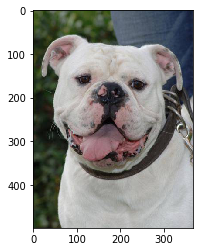

In [94]:
plt.imshow(image)

The dataset includes 20000 training images and 5000 test images, each image at a different resolution. Loading all this data at once requires too much memory, so we will need to **resize** each image to a smaller, common size as we load them from disk. We can do so by again making use of a *scikit-image* function. For example:

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


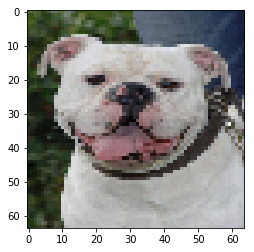

In [95]:
size = 64
smallimage = resize(image, (64, 64, 3), mode="reflect")  # 64 x 64 pixels, 3 color channels
plt.imshow(smallimage)


<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    
Perform the following tasks to prepare the data:
- Build a numpy array *X_train* containing one entry for each training image in the data. Each entry must contain the 3-dimensional matrix of pixels corresponding to an image. Make sure to scale down each image to a common size
- Normalize *X_train* so that pixels follow a distribution lying in the range [-0.5,0.5]
- Build a corresponding array *Y_train* with the class of each training image (0 for cats and 1 for dogs).
- Randomly shuffle the data. Make sure you shuffle both *X_train* and *Y_train* using the same permutation, so you don't lose track of the class of each training pattern.

- Repeat the whole procedure again to generate *X_test* and *Y_test* matrices for the test data.
</font>

***

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
- Take advantage of the *glob* package to generate the filename lists for the indoor and outdoor subfolders.
- Since you need to repeat the procedure both for training and test data, it would be useful to implement a function that performs all the data loading and transforming steps.
</font>

***

Creamos una función que tomando una imagen la reescala, creando un cubo de datos con el tamaño de la imagen (filas y columnas) y el número de canales. (tamaño de las filas, tamaño de las columnas, canales (RGB)). Además desplazamos la distribución de pixeles originales entre $[0,1]$ a $[-0.5,0.5]$.

In [0]:
def preprocesing(image, size = 64, mode = "reflect"):
    return(np.array(resize(imread(image), (size, size, 3), mode=mode, anti_aliasing=True)-0.5))

In [97]:
X_train = []
Y_train = []
X_test = []
Y_test = []

print("Loading cats train")
for image in glob.glob('Data/train/cats/*.jpg'):
    X_train.append(preprocesing(image))
    Y_train.append(0)
print("Loading dogs train")
for image in glob.glob('Data/train/dogs/*.jpg'):
    X_train.append(preprocesing(image))
    Y_train.append(1)
print("Loading cats test")
for image in glob.glob('Data/test/cats/*.jpg'):
    X_test.append(preprocesing(image))
    Y_test.append(0)
print("Loading dogs test")
for image in glob.glob('Data/test/dogs/*.jpg'):
    X_test.append(preprocesing(image))
    Y_test.append(1)
print("Complete")

Loading cats train
Loading dogs train
Loading cats test
Loading dogs test
Complete


If everything has been properly loaded both X_train and Y_train lists should have equal length, and the same should happen for the pair X_test and Y_test.

In [98]:
print("X_train size", len(X_train))
print("Y_train size", len(Y_train))
print("X_test size", len(X_test))
print("Y_test size", len(Y_test))

X_train size 20000
Y_train size 20000
X_test size 5000
Y_test size 5000


Cambiamos el formato de X_train y X_test a un ndarray con (número de imagenes, 64, 64, 3) y mezclamos las imágenes. En este trabajo no se trabajará con imagenes con mayor resulición ya que sino podemos tener problemas de memoria.

In [0]:
np.random.seed(12)
index_train = np.arange(20000)
np.random.shuffle(index_train)
index_test = np.arange(5000)
np.random.shuffle(index_test)

In [0]:
X_train = np.asarray(X_train)[index_train]
X_test = np.asarray(X_test)[index_test]
Y_train = np.asarray(Y_train)[index_train]
Y_test = np.asarray(Y_test)[index_test]

Modificamos las etiquetas creando las categorías.  

In [0]:
from keras.utils import np_utils

In [0]:
Y_train = np_utils.to_categorical(Y_train, 2)
Y_test = np_utils.to_categorical(Y_test, 2)

## Basic deep model

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/question.png" height="80" width="80" style="float: right;"/>

***
<font color=#ad3e26>
Create a deep network that achieves at least a 60% of accuracy in the test set. Make use of the layers you seem fit for problem. You cannot use the test data for fitting the network, but you can use it to check the final performance of different network architectures, and select the architecture performing best.</font>

***

En esta primera parte mostraré algunas de las CNN que he probado y que van aumentando en complejidad hasta la arquitectura elegida:

<ol>
1. CNN 1:
    <br>
    <ul>
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes valid)
        <li> Capa de MaxPooling (2,2)
        <li> Capa Flatten
        <li> Capa Densa con 2 neuronas (Con función de activación sigmoide)
    </ul>  
2. CNN 2:
    <ul>
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes valid)
        <li> Capa de MaxPooling (2,2)
        <li> Capa Flatten
        <li> Capa densa con 64 neuronas (Con función de activación Relu) y dropout (0.5)
        <li> Capa densa con 2 neuronas (Con función de activación sigmoide)
    </ul>
3. CNN 3:
    <ul>
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes valid)
        <li> Capa de MaxPooling (2,2)
        <li> 64 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes valid)
        <li> Capa de MaxPooling (2,2)
        <li> Capa Flatten
        <li> Capa densa con 256 neuronas (Con función de activación Relu) y dropout (0.5)
        <li> Capa densa con 2 neuronas (Con función de activación sigmoide)
    </ul>
4. CNN 4: 
    <ul>
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 64 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 128 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 256 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> Capa Flatten
        <li> Capa densa con 512 neuronas (Con función de activación Relu) y dropout (0.5)
        <li> Capa densa con 2 neuronas (Con función de activación sigmoide)
    </ul>
5. CNN 5:
    <ul>
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 64 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> 64 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 128 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> 128 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 256 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> Capa Flatten
        <li> Capa densa con 512 neuronas (Con función de activación Relu) y dropout (0.5)
        <li> Capa densa con 2 neuronas (Con función de activación sigmoide)
    </ul>
  </ol>

Antes de utilizar estos modelos es necario tomar algunas consideraciones.
<ol>
<li> <b>Función de pérdida</b> </li>
    <ul>
De entre la gran variedad de funciones de pérdida disponibles en keras, he elegido <b>binary crossentropy</b> puesto que tenemos un problema de clasificiación con solamente dos clases. Esta se puede expresar como:

$$H_p(q) = -\frac{1}{N_0 + N_1}[\sum_{i=1}^{N_0}log(p(y_i)) + \sum_{i=1}^{N_1}log(p(y_i))]$$
con $N_0$ el número de gatos y $N_1$ el número de perros. 
</ul>
<li> <b>Solver de optimización</b> </li>
<ul> 
En este caso utilizaremos el solver de optimización <b>adam</b> ya que funciona bien para problemas con muchos datos y/o parámetros.
</ul>
<li> <b>Número de epochs</b> </li>
<ul>    
Designa el número de veces que la red neuronal utilizará todos los datos de entrenamiento para actualizar los pesos. En este caso, de manera un poco manual considero que unas <b>10</b> o <b>20</b> epochs son suficientes. 
</ul>
<li> <b>Tamaño del batch</b> </li>
<ul>   
Designa el tamaño del subconjunto de datos tomados de train para actualizar los parámetros. En este caso utilizaremos <b>128</b>, lo que equivale sobre nuestro dataset de 20000 imágenes de entrenamiento a unas 150 imágnes. 
</ul>
<li> <b>Métrica</b> </li>
<ul>
Puesto que tenemos un problema con las clases perfectamente balanceadas podemos utilizar una métrica simple como es <b>accuracy</b>. 
</ol>

## CNN 1

Creamos la arquitectura del modelo y lo compilamos con el solver anterior y la función de perdida anterior. 

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='valid', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Entrenamos la red con el tamaño del batch y el número de epochs

In [147]:
model.fit(
    X_train, 
    Y_train, 
    batch_size=128, 
    epochs=20, 
    verbose=2 
)

Epoch 1/20
 - 8s - loss: 0.6120 - acc: 0.6616
Epoch 2/20
 - 3s - loss: 0.5482 - acc: 0.7269
Epoch 3/20
 - 3s - loss: 0.5170 - acc: 0.7510
Epoch 4/20
 - 3s - loss: 0.4915 - acc: 0.7661
Epoch 5/20
 - 3s - loss: 0.4737 - acc: 0.7780
Epoch 6/20
 - 3s - loss: 0.4528 - acc: 0.7891
Epoch 7/20
 - 3s - loss: 0.4362 - acc: 0.8056
Epoch 8/20
 - 3s - loss: 0.4263 - acc: 0.8103
Epoch 9/20
 - 3s - loss: 0.4159 - acc: 0.8135
Epoch 10/20
 - 3s - loss: 0.4048 - acc: 0.8224
Epoch 11/20
 - 3s - loss: 0.4051 - acc: 0.8182
Epoch 12/20
 - 3s - loss: 0.3876 - acc: 0.8310
Epoch 13/20
 - 3s - loss: 0.3783 - acc: 0.8360
Epoch 14/20
 - 3s - loss: 0.3758 - acc: 0.8370
Epoch 15/20
 - 3s - loss: 0.3648 - acc: 0.8425
Epoch 16/20
 - 3s - loss: 0.3614 - acc: 0.8436
Epoch 17/20
 - 3s - loss: 0.3464 - acc: 0.8539
Epoch 18/20
 - 3s - loss: 0.3439 - acc: 0.8531
Epoch 19/20
 - 3s - loss: 0.3364 - acc: 0.8585
Epoch 20/20
 - 3s - loss: 0.3322 - acc: 0.8606


Vemos la actuación del modelo sobre los datos de test.

In [148]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 3s 578us/step
Test loss 0.4930
Test accuracy 0.7714


Con este modelo bastante simple conseguimos un accuracy mayor del 70%

## CNN 2

Estudiemos los resultados con la segunda arquitectura considerada.

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='valid', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [107]:
model.fit(
    X_train, 
    Y_train, 
    batch_size=128, 
    epochs=20, 
    verbose=2 
)

Epoch 1/20
 - 3s - loss: 0.6695 - acc: 0.5603
Epoch 2/20
 - 2s - loss: 0.6369 - acc: 0.5947
Epoch 3/20
 - 2s - loss: 0.6210 - acc: 0.6036
Epoch 4/20
 - 2s - loss: 0.6067 - acc: 0.6145
Epoch 5/20
 - 2s - loss: 0.5932 - acc: 0.6323
Epoch 6/20
 - 2s - loss: 0.5770 - acc: 0.6701
Epoch 7/20
 - 2s - loss: 0.5578 - acc: 0.6854
Epoch 8/20
 - 2s - loss: 0.5438 - acc: 0.6968
Epoch 9/20
 - 2s - loss: 0.5357 - acc: 0.7003
Epoch 10/20
 - 2s - loss: 0.5268 - acc: 0.7087
Epoch 11/20
 - 2s - loss: 0.5232 - acc: 0.7116
Epoch 12/20
 - 2s - loss: 0.5114 - acc: 0.7193
Epoch 13/20
 - 2s - loss: 0.4998 - acc: 0.7272
Epoch 14/20
 - 2s - loss: 0.4942 - acc: 0.7349
Epoch 15/20
 - 2s - loss: 0.4915 - acc: 0.7330
Epoch 16/20
 - 2s - loss: 0.4786 - acc: 0.7362
Epoch 17/20
 - 2s - loss: 0.4728 - acc: 0.7407
Epoch 18/20
 - 2s - loss: 0.4650 - acc: 0.7462
Epoch 19/20
 - 2s - loss: 0.4625 - acc: 0.7452
Epoch 20/20
 - 2s - loss: 0.4496 - acc: 0.7551


In [108]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 1s 245us/step
Test loss 0.4862
Test accuracy 0.7586


Tenemos un resultado similar al del modelo anterior.

## CNN 3

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='valid', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(64, (kernel_size, kernel_size), padding='valid'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [110]:
model.fit(
    X_train, 
    Y_train, 
    batch_size=128, 
    epochs=20, 
    verbose=2 
)

Epoch 1/20
 - 5s - loss: 0.6064 - acc: 0.6624
Epoch 2/20
 - 3s - loss: 0.4988 - acc: 0.7603
Epoch 3/20
 - 3s - loss: 0.4461 - acc: 0.7931
Epoch 4/20
 - 3s - loss: 0.4060 - acc: 0.8137
Epoch 5/20
 - 3s - loss: 0.3799 - acc: 0.8295
Epoch 6/20
 - 3s - loss: 0.3396 - acc: 0.8507
Epoch 7/20
 - 3s - loss: 0.3000 - acc: 0.8706
Epoch 8/20
 - 3s - loss: 0.2564 - acc: 0.8953
Epoch 9/20
 - 3s - loss: 0.2203 - acc: 0.9105
Epoch 10/20
 - 3s - loss: 0.1706 - acc: 0.9347
Epoch 11/20
 - 3s - loss: 0.1444 - acc: 0.9447
Epoch 12/20
 - 3s - loss: 0.1109 - acc: 0.9605
Epoch 13/20
 - 3s - loss: 0.0866 - acc: 0.9700
Epoch 14/20
 - 3s - loss: 0.0732 - acc: 0.9760
Epoch 15/20
 - 3s - loss: 0.0609 - acc: 0.9801
Epoch 16/20
 - 3s - loss: 0.0549 - acc: 0.9819
Epoch 17/20
 - 3s - loss: 0.0482 - acc: 0.9837
Epoch 18/20
 - 3s - loss: 0.0365 - acc: 0.9885
Epoch 19/20
 - 3s - loss: 0.0365 - acc: 0.9885
Epoch 20/20
 - 3s - loss: 0.0321 - acc: 0.9899


In [111]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 1s 233us/step
Test loss 0.7379
Test accuracy 0.8228


En este caso conseguimos superar el 80% de accuracy. Sin embargo, si vemos el accuracy durante el entrenamiento, el modelo está realizando un claro overfit. 

## CNN 4

Notese que en este caso utilizamos el enfoque *same* ya que al utilizar tantas capas de MaxPooling necesitamos preservar que el tamaño de la imagen tras pasar las capas de convolución sea razonable.  

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='same', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(64, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(128, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(256, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [113]:
model.fit(
    X_train, 
    Y_train, 
    batch_size=128, 
    epochs=10, 
    verbose=2 
)

Epoch 1/10
 - 6s - loss: 0.6267 - acc: 0.6354
Epoch 2/10
 - 4s - loss: 0.5008 - acc: 0.7543
Epoch 3/10
 - 4s - loss: 0.4131 - acc: 0.8120
Epoch 4/10
 - 4s - loss: 0.3506 - acc: 0.8463
Epoch 5/10
 - 4s - loss: 0.2931 - acc: 0.8726
Epoch 6/10
 - 4s - loss: 0.2481 - acc: 0.8943
Epoch 7/10
 - 4s - loss: 0.2000 - acc: 0.9173
Epoch 8/10
 - 4s - loss: 0.1447 - acc: 0.9437
Epoch 9/10
 - 4s - loss: 0.1067 - acc: 0.9583
Epoch 10/10
 - 4s - loss: 0.0748 - acc: 0.9722


In [114]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 1s 254us/step
Test loss 0.4326
Test accuracy 0.8615


Mejoramos el resultado anterior pero claramente la red sigue haciendo overfitting. 

## CNN 5

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='same', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(Convolution2D(32, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(64, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(Convolution2D(64, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(128, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(Convolution2D(128, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(256, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [116]:
model.fit(
    X_train, 
    Y_train, 
    batch_size=128, 
    epochs=10, 
    verbose=2 
)

Epoch 1/10
 - 10s - loss: 0.6558 - acc: 0.5910
Epoch 2/10
 - 8s - loss: 0.5411 - acc: 0.7281
Epoch 3/10
 - 8s - loss: 0.4429 - acc: 0.7975
Epoch 4/10
 - 8s - loss: 0.3596 - acc: 0.8409
Epoch 5/10
 - 8s - loss: 0.3094 - acc: 0.8673
Epoch 6/10
 - 8s - loss: 0.2605 - acc: 0.8899
Epoch 7/10
 - 8s - loss: 0.2275 - acc: 0.9059
Epoch 8/10
 - 8s - loss: 0.1860 - acc: 0.9236
Epoch 9/10
 - 8s - loss: 0.1596 - acc: 0.9367
Epoch 10/10
 - 8s - loss: 0.1346 - acc: 0.9449


In [117]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 2s 314us/step
Test loss 0.3029
Test accuracy 0.8857


Obtenemos el mejor resultado hasta al momento llegando casi al 90% de acierto. En este caso aunque la red sigue haciendo overfitting este no es tan pronunciado como las CNN anteriores. Así, quedemonos con esta arquitectura. 

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
    
If you are unable to attain the required 60% of accuracy, or your accuracy is too close to 100%, review the following checklist:
- Have you mixed training and test data?
- Have the values of the pixels been normalized?
- Have you compiled the model with a loss function appropriate for **binary** classification?
- Have you used ReLU units in the hidden layers? Have you used sigmoid or softmax layers in the output layer?

***

## Improving the network

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/pro.png" height="80" width="80" style="float: right;"/>

***

<font color=#259b4c>
    
You can further improve your results by applying one or more of the following strategies:
<li>
Keep apart a portion of the training data as a **validation set**. Then use an <a href="https://keras.io/callbacks/#earlystopping">**EarlyStopping strategy**</a> to monitor the loss of these validation data, and stop when training when after a number of iterations such loss has not decreased.
<li>
Make use of **metamodelling techniques** to select the best architecture parameters for the networks. You can use scikit-learn methods GridSearchCV or RandomSearchCV. You can do those by using the <a href="https://keras.io/scikit-learn-api/">KerasClassifier</a> wrapper. Even better, you can mix KerasClassifier with an advanced search method such as [BayesSearch](https://scikit-optimize.github.io/#skopt.BayesSearchCV), included in the [scikit-optimize](https://scikit-optimize.github.io/) library.
<li>
Use **image augmentation techniques** to artifically create new training images. To do so, you can make use of <a href="https://keras.io/preprocessing/image/">ImageDataGenerator</a> in Keras.
<li>
Make use of a pre-trained large network, building your network on top of it. You can find some examples in the [Keras Applications](https://keras.io/applications/) page.

If you correctly use these techniques you should be able to improve your model. With some effort it is possible to up to a 90% test accuracy. Try to do your best!</font>

***

IMPORTANTE

Ejecutar esta parte del código sin google colab requiere una gran cantidad de tiempo de entrenamiento. De esta manera, he guardado el modelo creado en el entorno de google colab en github. 

Una vez seleccionada la arquitectura de la red neuronal intentaremos mejorar el rendimiento de esta mediante las técnicas sugeridas. En concreto nos basaremos principalmente en dos de ellas:

<ol>
<li> <b>EarlyStopping strategy</b> </li>
    <ul>
Permite detener el entrenamiento si la función de pérdida en el conjunto de validación no decrece durante un cierto número de epochs, en concreto utilizaremos 5 epochs como margen. Puesto que 5 iteraciones pueden llevar a un mayor ovefit sin una mejora en el modelo, utilizaremos el parámetro <b>restore_best_weights</b> el cual devuelve los mejores pesos de las últimas 5 epochs en caso de que la función de perdida no decrezca durante estas iteraciones. Esta es una estrategia muy buena para controlar el overfit en las CNN.
</ul>

<li> <b>ImageDataGenerator</b> </li>
<ul> 
Esta técnica permite modificar las imagenes de train ligeramente mediante rotaciones, translaciones, zoom... Con esto se logra aumentar cosiderablemente el número de imágenes con las que entrenas el modelo sin necesidad de disponer de imágenes nuevas. 
</ul>
<br>

Para poder llevar a cabo las técnicas anteriormente comentadas es necesario separar un porcentaje de imágenes que utilizaremos para ir validando el modelo. Así, utilizaremos 2000 imágenes para validar y las 18000 restantes junto con la tecnica de aumentación de imágenes para entrenar la red. 

In [0]:
X_validate = X_train[0:2000]
Y_validate = Y_train[0:2000]
X_not_validate = X_train[2000:len(X_train)]
Y_not_validate = Y_train[2000:len(X_train)]

Creamos el generador de imágenes.

In [0]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect')

datagen.fit(X_not_validate)

Definimos la arquitectura.

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='same', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(Convolution2D(32, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(64, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(Convolution2D(64, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(128, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(Convolution2D(128, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(256, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

En este caso aumentamos el número de epochs a 100, ya que EarlyStopping detendrá el algoritmo cuando la función de perdida del set de validación no decrezca.

In [0]:
# Ejecutar solamente en google colab o en un entorno con GPU

model_final = model.fit_generator(datagen.flow(X_not_validate, Y_not_validate, batch_size=128),
                    steps_per_epoch=len(X_not_validate)/128, epochs=100, verbose=0,
                    validation_data = (X_validate, Y_validate),
                    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, restore_best_weights=True)] 
)

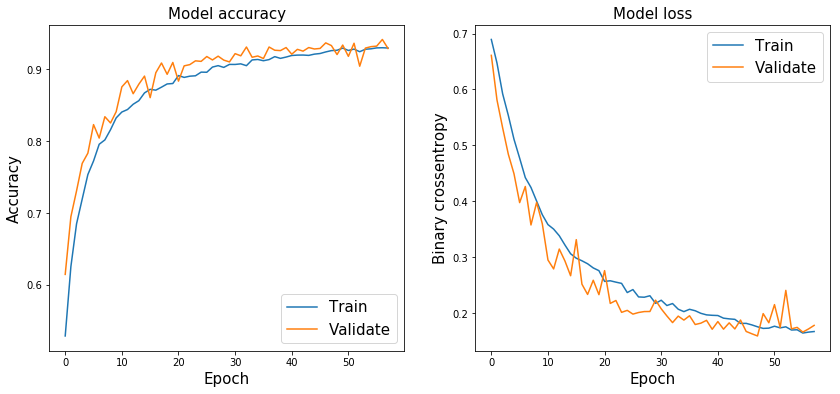

In [334]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(model_final.history['acc'])
plt.plot(model_final.history['val_acc'])
plt.title('Model accuracy', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Validate'], loc='best', fontsize = 15)

plt.subplot(122)
plt.plot(model_final.history['loss'])
plt.plot(model_final.history['val_loss'])
plt.title('Model loss', fontsize=15)
plt.ylabel('Binary crossentropy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Validate'], loc='best', fontsize = 15)
plt.show()

In [123]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 1s 218us/step
Test loss 0.1504
Test accuracy 0.9388


De esta manera utilizando estas técnicas, conseguimos mejorar el accuracy sobre el test entorno al $5$-$6\%$ con un modelo con la misma arquitectura. 

De las técnias sugeridas he intentado utilizar GridSearchCV para optimizar el número de neuronas por capa o el porcentaje de dropout de las capas densas..., sin embargo si se intenta trabajar con todas las imagenes nos quedamos sin memoria rapidamente. De esta manera utilizo una porción reducida de imagenes (12000) para intentar determinar el porcentaje de dropout óptimo. Realizo este proceso más para ilustrar como combinar GridSearchCV de sklearn con Keras, que para sacar un verdadero beneficio para construir el modelo.

In [0]:
def create_model(dropout_rate=0.0):
  
  img_rows = 64
  img_cols = 64
  kernel_size = 3 
  pool_size = 2

  model_drop = Sequential()

  model_drop.add(Convolution2D(32, (kernel_size, kernel_size),
                          padding='same', input_shape=(img_rows, img_cols, 3)))
  model_drop.add(Activation("relu"))
  model_drop.add(Convolution2D(32, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model_drop.add(Convolution2D(64, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(Convolution2D(64, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model_drop.add(Convolution2D(128, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(Convolution2D(128, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model_drop.add(Convolution2D(256, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model_drop.add(Flatten())
  model_drop.add(Dense(512))
  model_drop.add(Activation("relu"))
  model.add(Dropout(dropout_rate))
  model_drop.add(Dense(2))
  model_drop.add(Activation("sigmoid"))
  
  model_drop.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model_drop

In [125]:
model_drop = KerasClassifier(build_fn=create_model, epochs=20, batch_size=128, verbose=0)
dropout_rate = [0.1,0.5,0.9]
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model_drop, param_grid=param_grid, cv = 3)
t0 = time.time()
grid_result = grid.fit(X_train[0:3000], Y_train[0:3000])
print("Tiempo de búsqueda:", np.round((time.time()-t0)/60,1), "min")

Tiempo de búsqueda: 3.6 min


In [126]:
print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean, stdev, param in zip(grid_result.cv_results_['mean_test_score'],
                              grid_result.cv_results_['std_test_score'],
                              grid_result.cv_results_['params']):
    print("Accuracy %f std (%f) con: %r" % (mean, stdev, param))

Best accuracy: 0.707333 using {'dropout_rate': 0.5}
Accuracy 0.702833 std (0.023218) con: {'dropout_rate': 0.1}
Accuracy 0.707333 std (0.006956) con: {'dropout_rate': 0.5}
Accuracy 0.662000 std (0.017440) con: {'dropout_rate': 0.9}


En este caso para  las tres posibilidades estudiadas, el modelo obtiene los mejores resultados para un dropout de 0.5 como veniamos utilizando hasta ahora.  

Llegados a este punto ya tenemos un buen modelo que consigue un accuracy de más del 90%. Probemos ahora a modificar un modelo ya existente para ver si logramos mejorar el resultado.

En este caso utilizaremos el modelo VGG16 presentado originalmente en el paper <a href = "https://arxiv.org/abs/1409.1556">Very Deep Convolutional Networks for Large-Scale Image Recognition</a> por K. Simonyan and A. Zisserman de la universidad de Oxford. Este presenta la siguiente arquitectura:



<td style="height:200px;">
    <table>
         <tr>
              <td><img src="https://raw.githubusercontent.com/fjtm/Data/master/img/vgg16.png"   height="200" width="800"></td>   
         </tr>
         <tr>
              <td><img src="https://raw.githubusercontent.com/fjtm/Data/master/img/vgg16-1-e1542731207177.png" height="400" width="800"></td>
         </tr>
    </table>
</td>

En concreto el modelo que podemos importar de keras solamente tiene las capas convolucionales,  y por tanto es necesario crear manualmente las capas densas. Además, este modelo toma imágenes de 226x226 y puesto que por impedimentos de memoria estamos trabajando con imágenes de 64x64, será necesario introducir otra capa inicial para redefinir el tamaño de entrada. 

Así nuestro modelo seguirá la estructura: 

<li> Capa de entrada (64,64,3)
<li> Estructura convolucional del modelo vvg16
<li> Flatten
<li> Capa densa de 512 neuronas con activación relu y dropout del 50%.
<li> Capa densa de 2 neuronas con activación sigmoide

In [138]:
model_vgg16 = vgg16.VGG16(include_top=False, weights='imagenet', classes = 2)

input = Input(shape=(64,64,3))
model_vgg16_mod = model_vgg16(input)

x = Flatten(name='flatten')(model_vgg16_mod)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)
 
vgg16_tune_model = Model(input=input, output=x)

vgg16_tune_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [139]:
# Ejecutar solamente en google colab o en un entorno con GPU

vgg16_tune_model_results = vgg16_tune_model.fit_generator(datagen.flow(X_not_validate, Y_not_validate, batch_size=128),
                    steps_per_epoch=len(X_not_validate)/128, epochs=100, verbose=2,
                    validation_data = (X_validate, Y_validate),
                    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, restore_best_weights=True)] 
)

Epoch 1/100
 - 31s - loss: 0.6870 - acc: 0.5648 - val_loss: 0.6547 - val_acc: 0.5997
Epoch 2/100
 - 24s - loss: 0.5777 - acc: 0.7030 - val_loss: 0.4736 - val_acc: 0.7905
Epoch 3/100
 - 24s - loss: 0.4914 - acc: 0.7654 - val_loss: 0.3742 - val_acc: 0.8333
Epoch 4/100
 - 24s - loss: 0.4281 - acc: 0.8039 - val_loss: 0.3441 - val_acc: 0.8497
Epoch 5/100
 - 25s - loss: 0.3822 - acc: 0.8306 - val_loss: 0.3197 - val_acc: 0.8683
Epoch 6/100
 - 24s - loss: 0.3561 - acc: 0.8445 - val_loss: 0.2641 - val_acc: 0.8862
Epoch 7/100
 - 24s - loss: 0.3287 - acc: 0.8567 - val_loss: 0.2516 - val_acc: 0.8965
Epoch 8/100
 - 24s - loss: 0.3235 - acc: 0.8601 - val_loss: 0.2839 - val_acc: 0.8840
Epoch 9/100
 - 26s - loss: 0.2868 - acc: 0.8785 - val_loss: 0.2919 - val_acc: 0.8973
Epoch 10/100
 - 24s - loss: 0.2869 - acc: 0.8796 - val_loss: 0.2092 - val_acc: 0.9177
Epoch 11/100
 - 24s - loss: 0.2541 - acc: 0.8939 - val_loss: 0.3147 - val_acc: 0.8712
Epoch 12/100
 - 25s - loss: 0.2735 - acc: 0.8850 - val_loss: 0.

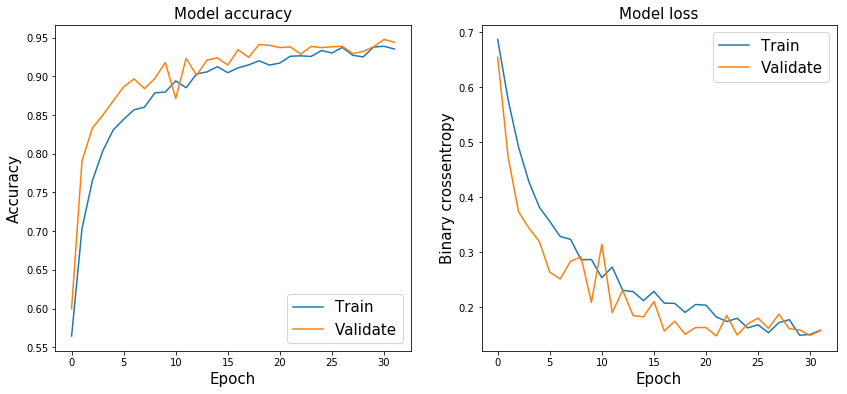

In [332]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(vgg16_tune_model_results.history['acc'])
plt.plot(vgg16_tune_model_results.history['val_acc'])
plt.title('Model accuracy', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Validate'], loc='best', fontsize = 15)

plt.subplot(122)
plt.plot(vgg16_tune_model_results.history['loss'])
plt.plot(vgg16_tune_model_results.history['val_loss'])
plt.title('Model loss', fontsize=15)
plt.ylabel('Binary crossentropy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Validate'], loc='best', fontsize = 15)
plt.show()

In [141]:
score = vgg16_tune_model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 3s 650us/step
Test loss 0.1414
Test accuracy 0.9414


## Analyzing the results

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Find and show some test images for which your model fails. Can you give an explanation for this behavior?</font>

***

Veamos algunas imágenes mal clasificadas por la CNN construida desde cero, es decir, nos centraremos en el último modelo construido sin contar el vgg16. Para ello representemos 12 de las imágenes mal clasificadas. Cabe destacar que cada vez que se ejecuta el código los parámetros de la red pueden cambiar y por tanto las imágenes erroneamente clasificadas también (además de alterarse el orden). Por tanto, me centraré en explicar las causas en general por las que considero que el modelo falla más que en detenerme en cada fotografía. 

In [0]:
pred = model.predict_classes(X_test)
real = Y_test.argmax(1)
fails = np.where(real != pred)[0]

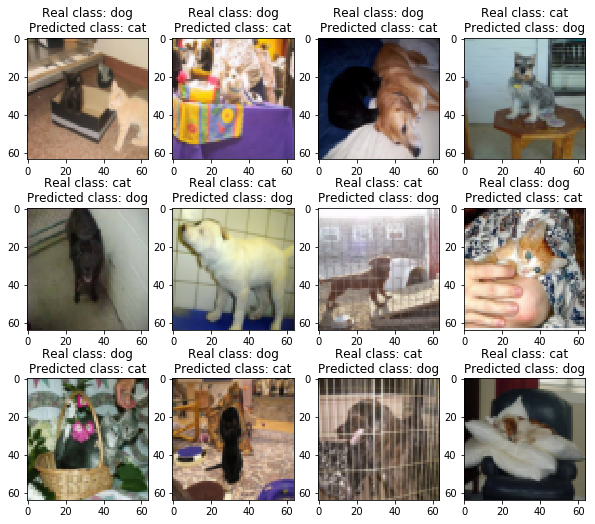

In [336]:
plt.figure(figsize=(10, 12))
for j, i in enumerate(range(0,12)):
  plt.subplot(4,4,j+1)
  plt.imshow(X_test[fails[i]]+0.5, 'gray')
  if real[fails[i]] == 1:
    real_label = "cat"
    predicted_label = "dog"
  else:
    real_label = "dog"
    predicted_label = "cat"
  plt.title("Real class: " + real_label + "\n" + "Predicted class: " + predicted_label)

No siempre es fácil entender porque el modelo falla en sus predicciones, aunque en ocasiones se puede suponer el porqué. Las siguientes posibles causas que he encontrado viendo las imagnes son:

<li> La imagen no es ni un gato ni un perro. Hay algunas imágenes que no contienen animales, hay alguna fotografías en las que sale solamente una persona.
<li> Cuando el animal ocupa una porción muy pequeña de la imagen. Con la baja resolución a veces es difícil saber visualmente si es un perro o un gato.
<li> Si en la imagen aparecen varios animales en vez de uno solo. 
<li> Clasifica en muchos casos erroneamente los perros que son completamente negros, o por el contrario los gatos que son completamente marrones. 
<li> Falla en varias ocasiones cuando el animal esta detrás de una valla o una reja. 
<li> Cuando aparecen personas sujetando al perro o el gato en muchas ocasiones clasifica erroneamente. 
<li> Creo que en algunos casos clasifica mal a los perros que tienen las orejas levantadas similares a como suelen ser las de los gatos.
<li> Finalmente creo que la posición en la que se encuentra el animal influye en algunos casos en la clasificación erronea. 
  
Teniendo todo esto en cuenta resulta sorprendente como la CNN es capaz de clasificar correctamente un porcentaje tan grande de imágenes. 

Miremos finalmente si los errores están balanceados entre clases.

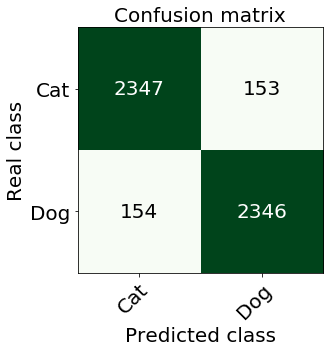

In [337]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
cm = confusion_matrix(real, pred)

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
               fontsize = 20)
        ax.set_ylabel('Real class', fontsize=20)
        ax.set_xlabel('Predicted class', fontsize=20)
        ax.set_title('Confusion matrix', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout()

Como vemos el modelo se equivoca por igual en las dos clases.

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Write a small report summarizing the network choices you have tried, what worked and what didn't. What have you learned from this experience?</font>

***

Valid, sin earlystopping ni nada.

Con capa densa de 16 neuronas


Convolucional 3 (32, 3, 3) (64, 3, 3) (128, 3, 3) un 86.1% batch_size=128


Convolucional 1 (32, 3, 3) un 77% de accuracy. Sin capa densa de 16 neuronas batch_size=128

Convolucional 2 (32, 3, 3) (32, 3, 3) un 79-80%. Sin capa densa de 16 neuronas batch_size=128

Convolucional 2 (32, 3, 3) (64, 3, 3) un 82.42%. Sin capa densa de 16 neuronas batch_size=128

Convolucional 3 (32, 3, 3) (64, 3, 3) (128, 3, 3) un 87.8% batch_size=128

Convolucional 3 (32, 3, 3) (64, 3, 3) (128, 3, 3) con una red densa 128 neuronas (90% drop out)  88.52% batch_size=128

Convolucional 3 (32, 3, 3) (64, 3, 3) (128, 3, 3) con una red densa 256 neuronas (95% drop out)  87.44% batch_size=128

Same. No da buenos resultados de momento.

